# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Commenti sull'implementazione

Le modifiche sono state implementate nel file `system.cpp`. All'interno della funzione `System::initialize_properties()`, le variabili `_vtail` e `_ptail`, inizialmente nulle, sono state aggiornate con le formule analitiche appropriate. `_vtail` ora contiene la correzione per l'energia potenziale per particella, mentre `_ptail` quella per la pressione. Il calcolo viene eseguito una sola volta all'inizio della simulazione, poiché dipende da parametri costanti come la densità ($\rho$) e il raggio di cutoff ($r_c$).

### Exercise 07.2

Use the NSL simulator code to <span style="color:red">print out **instantaneous** values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo $(N,V,T)$ and Molecular Dynamics $(N,V,E)$ simulations</span> of $M=5\times 10^5$ MC steps or MD time steps (where, for MC, the Metropolis acceptance ratio should be fixed approximately to 50% by changing the value of $dt$ that, in the MC case, represent the amplitude of the step in each direction) in the following thermodynamic conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, for MD $dt^\star=0.001$)

Equilibration is needed both with MC and with MD. With MD, you will observe that starting from a perfect crystalline configuration the temperature, $T$, will not conserve its value. Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$.
<span style="color:red">Perform your MC and MD simulations by re-starting after such equilibration time.</span>

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What do you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Commenti sull'implementazione

#### 1. Modifiche al codice C++

Le modifiche si sono concentrate sull'aggiunta di nuove funzionalità al simulatore esistente, principalmente nei file `system.h` e `system.cpp`.

* **Registrazione dati istantanei**
    Per registrare l'energia potenziale ad ogni passo della simulazione, sono stati aggiunti un `ofstream _cout_epot` e un contatore `int _step_count` come membri privati della classe `System`. La gestione del file è integrata nel ciclo di vita dell'oggetto: il file `../OUTPUT/instant_epot.dat` viene aperto in `initialize_properties()`, il contatore viene incrementato in `step()`, il valore dell'energia potenziale istantanea viene scritto su file all'interno della funzione `measure()` e il file stream viene chiuso in `finalize()`. Questo approccio modulare mantiene la logica di misurazione autoconsistente e fornisce i dati grezzi necessari per le analisi di correlazione temporale.

#### 2. Script Python di automazione

È stato sviluppato uno script Python (`run_simulations.py`) per automatizzare l'intero processo. La necessità di una fase di equilibrazione seguita da una di produzione rendeva l'esecuzione manuale ripetitiva. Lo script garantisce la riproducibilità eseguendo passaggi standardizzati.

* **Funzionalità chiave dello script:**
    * **Configurazione centralizzata:** Le simulazioni da eseguire sono definite in una lista, facilitando quindi future estensioni.
    * **Gestione del flusso equilibrazione/produzione:** Lo script esegue prima una simulazione di equilibrazione partendo da zero (`RESTART 0`), copia automaticamente i file di configurazione finali nella cartella di input, e infine lancia la simulazione di produzione in modalità restart (`RESTART 1`).
    * **Organizzazione dei risultati:** I file di output vengono spostati in cartelle dedicate per evitare sovrascritture e mantenere un archivio ordinato.

--- Caricamento e Preparazione Dati ---
Caricato 'NVT_LIQUID\instant_epot.dat': 500000 passi totali.
  -> Dati per l'analisi (NVT): 480000 passi.
Caricato 'NVE_LIQUID\instant_epot.dat': 500000 passi totali.
  -> Dati per l'analisi (NVE): 480000 passi.
-----------------------------------

--- Esecuzione Analisi e Creazione Grafici ---


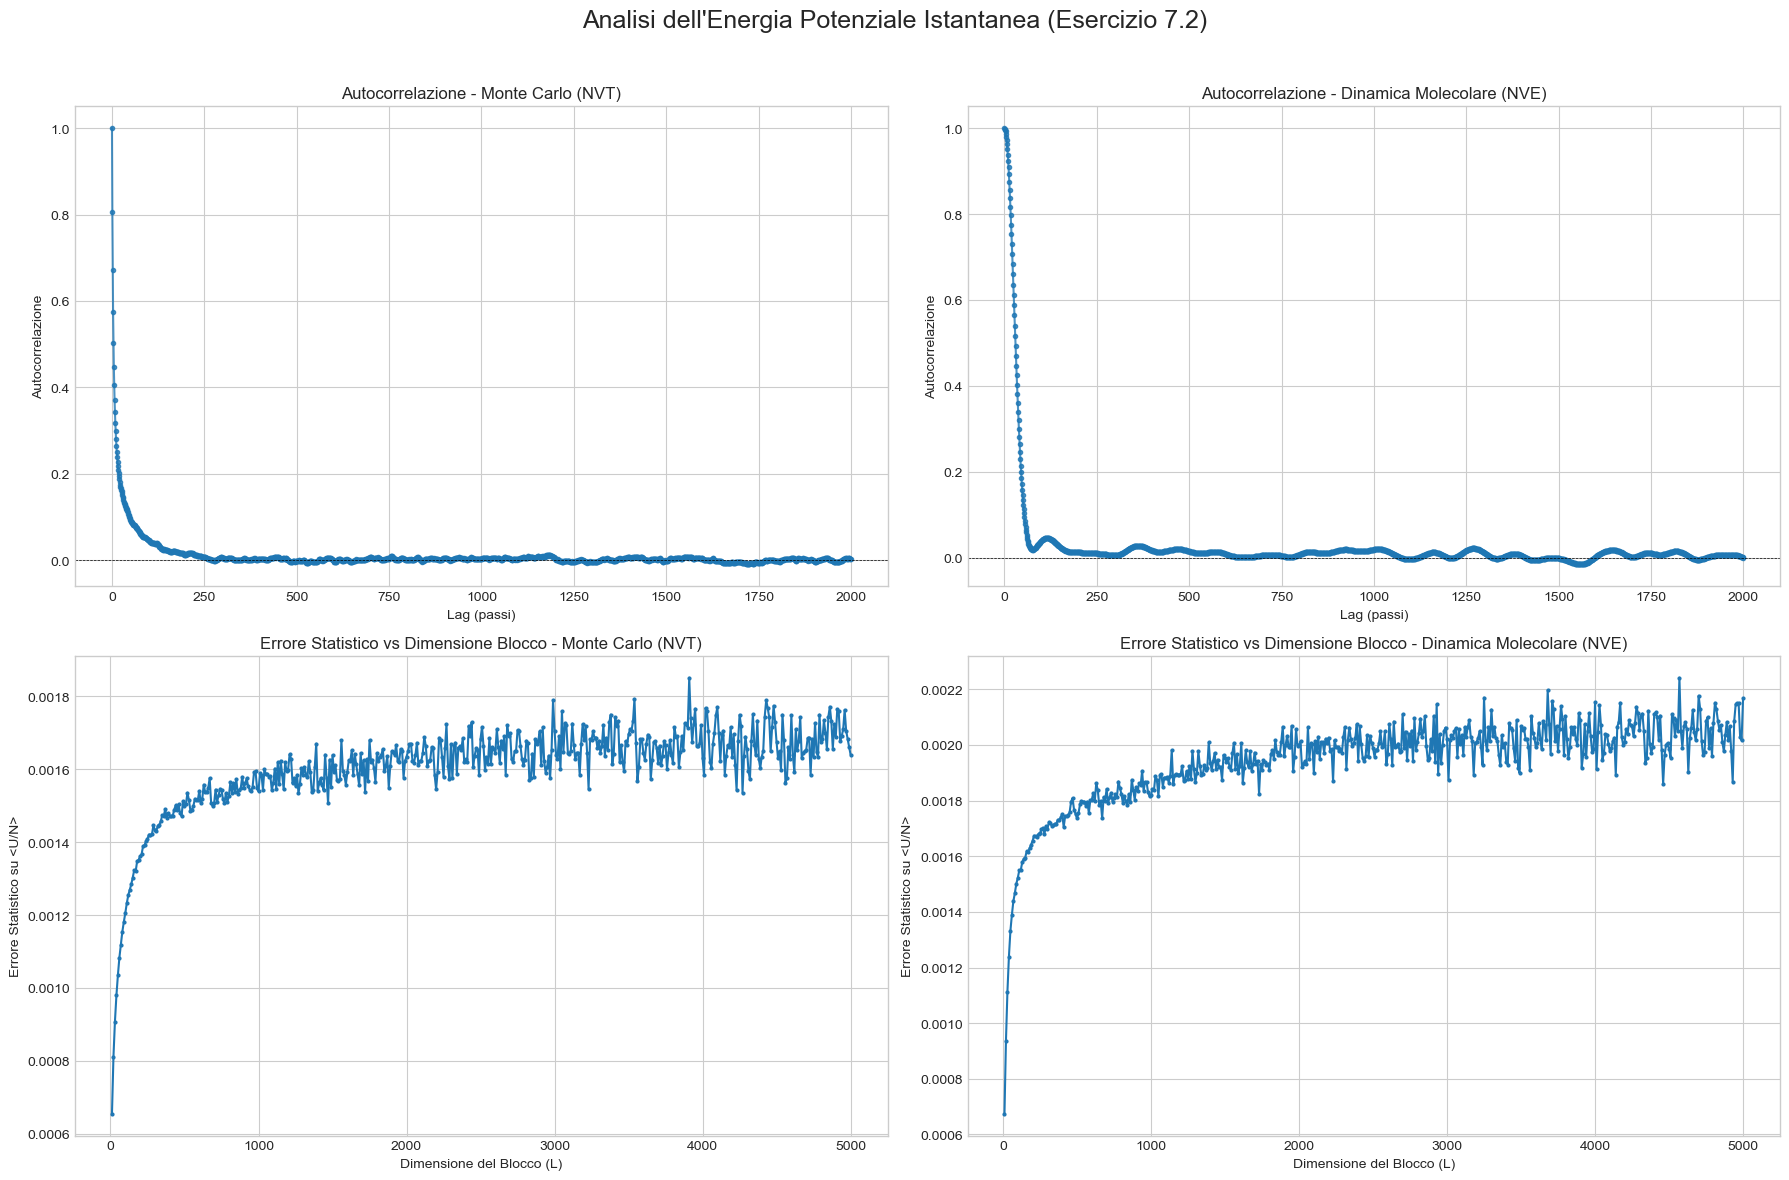

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configurazione e Caricamento Dati ---

# Imposta uno stile grafico
plt.style.use('seaborn-v0_8-whitegrid')

# Definiamo i nomi delle cartelle (devono corrispondere a quelle prodotte dallo script C++)
# e i titoli per i grafici.
simulations_to_analyze = {
    "NVT": {
        "folder": "NVT_LIQUID",
        "title": "Monte Carlo (NVT)"
    },
    "NVE": {
        "folder": "NVE_LIQUID",
        "title": "Dinamica Molecolare (NVE)"
    }
}

# Imposta il numero di passi da scartare per l'equilibrazione.
# Deve corrispondere a EQUILIBRATION_STEPS nello script di automazione.
equilibration_steps = 20000

# Dizionario per salvare i dati caricati ed equilibrati
datasets = {}

print("--- Caricamento e Preparazione Dati ---")
for key, sim_info in simulations_to_analyze.items():
    folder = sim_info["folder"]
    filename = os.path.join(folder, "instant_epot.dat")
    
    try:
        # Carica solo la colonna dell'energia potenziale
        u_pot_raw = np.loadtxt(filename, usecols=1)
        # Scarta i passi di equilibrazione
        u_pot_equilibrated = u_pot_raw[equilibration_steps:]
        datasets[key] = u_pot_equilibrated
        
        print(f"Caricato '{filename}': {len(u_pot_raw)} passi totali.")
        print(f"  -> Dati per l'analisi ({key}): {len(u_pot_equilibrated)} passi.")
        
    except FileNotFoundError:
        print(f"ERRORE: File '{filename}' non trovato.")
        print(f"  -> Assicurati che la cartella '{folder}' sia presente e contenga i dati.")

print("-" * 35 + "\n")


# --- 2. Funzioni per l'Analisi ---

def calculate_autocorrelation(data, max_lag):
    """Calcola la funzione di autocorrelazione normalizzata."""
    y = data - np.mean(data)
    norm = np.sum(y**2)
    autocorr = np.zeros(max_lag)
    for k in range(max_lag):
        covariance = np.sum(y[:-k-1] * y[k:-1])
        autocorr[k] = covariance / norm
    return autocorr

def calculate_blocking_error(data, max_block_size):
    """Calcola l'errore statistico in funzione della dimensione del blocco."""
    block_sizes = np.arange(10, max_block_size + 1, 10, dtype=int)
    errors = []
    
    for L in block_sizes:
        n_blocks = int(len(data) / L)
        if n_blocks > 1:
            block_averages = [np.mean(data[i*L:(i+1)*L]) for i in range(n_blocks)]
            mean_of_averages = np.mean(block_averages)
            sum_sq_diff = np.sum((np.array(block_averages) - mean_of_averages)**2)
            error = np.sqrt(sum_sq_diff / (n_blocks * (n_blocks - 1)))
            errors.append(error)
        else:
            errors.append(np.nan) # Non possiamo calcolare l'errore con meno di 2 blocchi
            
    return block_sizes, errors


# --- 3. Esecuzione Analisi e Creazione Grafici ---

# Se i dati sono stati caricati correttamente, procedi con l'analisi
if datasets:
    print("--- Esecuzione Analisi e Creazione Grafici ---")
    
    # Crea una figura con subplots per un layout più compatto
    # 2 righe (autocorrelazione, blocking) e 2 colonne (NVT, NVE)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle("Analisi dell'Energia Potenziale Istantanea (Esercizio 7.2)", fontsize=18)

    # Analisi dell'autocorrelazione
    max_lag = 2000
    for i, (key, data) in enumerate(datasets.items()):
        autocorr_data = calculate_autocorrelation(data, max_lag)
        ax = axes[0, i]
        ax.plot(autocorr_data, marker='o', linestyle='-', markersize=3, alpha=0.8)
        ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax.set_title(f"Autocorrelazione - {simulations_to_analyze[key]['title']}")
        ax.set_xlabel("Lag (passi)")
        ax.set_ylabel("Autocorrelazione")
        ax.grid(True)

    # Analisi blocchi
    max_block_size = 5000
    for i, (key, data) in enumerate(datasets.items()):
        block_sizes, errors = calculate_blocking_error(data, max_block_size)
        ax = axes[1, i]
        ax.plot(block_sizes, errors, marker='.', linestyle='-', markersize=4)
        ax.set_title(f"Errore Statistico vs Dimensione Blocco - {simulations_to_analyze[key]['title']}")
        ax.set_xlabel("Dimensione del Blocco (L)")
        ax.set_ylabel("Errore Statistico su <U/N>")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Aggiusta layout per far spazio al titolo principale
    plt.show()
else:
    print("\nAnalisi non eseguita perché non sono stati caricati dati.")

### Analisi dei risultati

#### Funzione di autocorrelazione

La funzione di autocorrelazione è utilizzata per stimare dopo quanti passi le misure diventano statisticamente indipendenti.

* **Monte Carlo (NVT)**: Il grafico di autocorrelazione mostra un decadimento relativamente lento, che si annulla dopo un "tempo" di circa 200-300 passi. Questo comportamento è atteso, poiché le mosse MC, essendo locali e casuali, fanno sì che una configurazione del sistema rimanga correlata a quelle immediatamente precedenti per un certo numero di iterazioni.

* **Dinamica Molecolare (NVE)**: Al contrario, la simulazione di dinamica molecolare presenta un decadimento decisamente più rapido. Questo risultato è corretto e riflette la natura deterministica dell'evoluzione del sistema, dove le velocità delle particelle portano a rapidi cambiamenti di configurazione, annullando la memoria degli stati precedenti in pochissimi passi.

#### Errore con data blocking
L'analisi dell'errore statistico in funzione della dimensione del blocco ($L$) mostra per entrambi i metodi l'andamento teorico atteso. L'errore stimato cresce all'aumentare di $L$ fino a raggiungere un *plateau*. Questo plateau indica che i blocchi hanno raggiunto una dimensione sufficiente per essere considerati statisticamente indipendenti, e il valore dell'errore in questa regione rappresenta la stima corretta dell'incertezza sulla media.

Le **oscillazioni** osservate nella regione di plateau del grafico dell'errore statistico sono un normale effetto statistico e non indicano un errore nella simulazione. Sono causate dalla riduzione del numero di blocchi ($N$) utilizzati per la stima dell'errore all'aumentare della dimensione del blocco ($L$).

Per un numero totale di dati fisso ($M_{tot}$), la relazione tra il numero di blocchi e la loro dimensione è $N = M_{tot} / L$. Di conseguenza, quando la dimensione del blocco $L$ diventa grande, il numero di blocchi $N$ diminuisce drasticamente. La stima dell'errore statistico, che si basa sulla deviazione standard delle medie di questi blocchi, diventa meno affidabile quando calcolata su un campione piccolo (un basso numero di blocchi). Questa ridotta robustezza statistica si manifesta come maggiori fluttuazioni, ovvero le "oscillazioni" visibili nel plateau.

### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Commenti sull'implementazione

È stato implementato il calcolo della funzione di distribuzione radiale, $g(r)$, modificando il file `system.cpp`.

**1. Raccolta dati nell'istogramma (System::measure)**
Nel ciclo che itera sulle coppie di particelle, è stata aggiunta una condizione per misurare la distanza interparticellare $dr$. Se la distanza rientra nell'intervallo di interesse ($dr < L/2$), viene identificato il bin corrispondente e il suo contatore viene incrementato di 2, tenendo conto della simmetria della coppia.

**2. Normalizzazione e output Finale (System::averages)**
Al termine dell'ultimo blocco di simulazione, un'apposita sezione di codice normalizza i dati raccolti. Per ogni bin dell'istogramma, viene calcolato il volume del guscio sferico corrispondente ($\Delta V$) e un fattore di normalizzazione basato su densità ($\rho$) e numero di particelle ($N$). Utilizzando i valori mediati sui blocchi, il codice calcola il valore finale di $g(r)$ e la relativa incertezza statistica, scrivendo i risultati su file.

### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and <span style="color:red">perform MC NVT and MD NVE simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for these quantities with those obtained via MD NVE simulations in similar thermodynamic conditions.</span>

### Commenti sull'implementazione

### Analisi delle Differenze tra Simulazioni NVT e NVE

Un'analisi dei risultati delle simulazioni ha evidenziato comportamenti distinti tra l'insieme NVT (Monte Carlo) e NVE (Dinamica Molecolare) che, sebbene possano apparire anomali, sono manifestazioni corrette delle differenze teoriche fondamentali tra i due metodi.

#### Simulazione NVT (Monte Carlo)

Nelle simulazioni NVT, si osserva che i valori misurati per l'**energia cinetica** e la **temperatura** sono costantemente pari a zero, mentre l'energia potenziale converge a un valore di equilibrio stabile. Questo comportamento è atteso e corretto.

* **Spiegazione teorica**: Il metodo Monte Carlo nell'insieme NVT esplora lo spazio delle configurazioni in modo stocastico e non si basa su una dinamica fisica che includa forze e velocità. La temperatura non è una grandezza misurata dall'energia cinetica, ma un parametro di input fisso che determina la probabilità di accettazione delle mosse tramite il fattore di Boltzmann. Poiché le velocità delle particelle non sono definite o aggiornate, l'energia cinetica e la temperatura da essa derivata sono correttamente nulle.
* **Verifica del codice**: L'implementazione in `system.cpp` riflette questa logica. La funzione `step()` per le simulazioni MC (`_sim_type == 1`) invoca la funzione `move()`, che modifica solo le posizioni. Le velocità vengono aggiornate esclusivamente dalla funzione `Verlet()`, che è chiamata solo per le simulazioni MD (`_sim_type == 0`).

#### Simulazione NVE (Dinamica Molecolare)

Nelle simulazioni NVE, si rileva un **rateo di accettazione** costantemente pari al 100%. Anche questo è un risultato atteso.

* **Spiegazione teorica**: La Dinamica Molecolare nell'insieme NVE è un metodo deterministico che integra le equazioni del moto di Newton (in questo caso, con l'algoritmo di Verlet). A differenza di MC, non esiste un test di accettazione stocastico; ogni passo calcolato viene eseguito. Pertanto, il concetto di "accettazione" è del 100% per definizione.
* **Verifica del codice**: Il codice in `system.cpp` implementa correttamente questo principio. Per ogni step di MD, sia il contatore delle mosse tentate (`_nattempts`) sia quello delle mosse accettate (`_naccepted`) vengono incrementati dello stesso valore (pari al numero di particelle), portando a un rateo di accettazione di 1.

Una prima analisi dei risultati ha rivelato una significativa discrepanza tra la **pressione** calcolata nella simulazione Monte Carlo (NVT) e quella della Dinamica Molecolare (NVE), con il valore NVT fisicamente scorretto. Il problema è stato identificato nel calcolo del contributo cinetico alla pressione ($P=\rho T + \text{termine viriale}$).

L'implementazione originale utilizzava la temperatura istantanea, derivata dall'energia cinetica media delle particelle, per calcolare il termine $\rho T$. Sebbene questo approccio sia corretto per la MD (NVE), risulta errato per le simulazioni MC (NVT), dove, come precedentemente spiegato, le particelle non possiedono velocità definite e l'energia cinetica è, per definizione, zero. Di conseguenza, il contributo cinetico alla pressione veniva erroneamente omesso.

La **correzione** è stata implementata nella funzione `System::measure()` nel file `system.cpp` attraverso un controllo sul tipo di simulazione (`_sim_type`). Per le simulazioni MD (NVE), il contributo cinetico continua a essere calcolato dalla temperatura istantanea (`kenergy_temp`). Per le simulazioni MC (NVT), invece, viene ora utilizzato il valore della temperatura (`_temp`), che è un parametro fisso.

--- Caricamento Dati Finali dalle Simulazioni ---
Caricata Energia Potenziale per NVT...
Caricata Pressione per NVT...
Caricata g(r) per NVT...
Caricata Energia Potenziale per NVE...
Caricata Pressione per NVE...
Caricata g(r) per NVE...
--------------------------------------------------

--- Creazione Grafici di Confronto ---


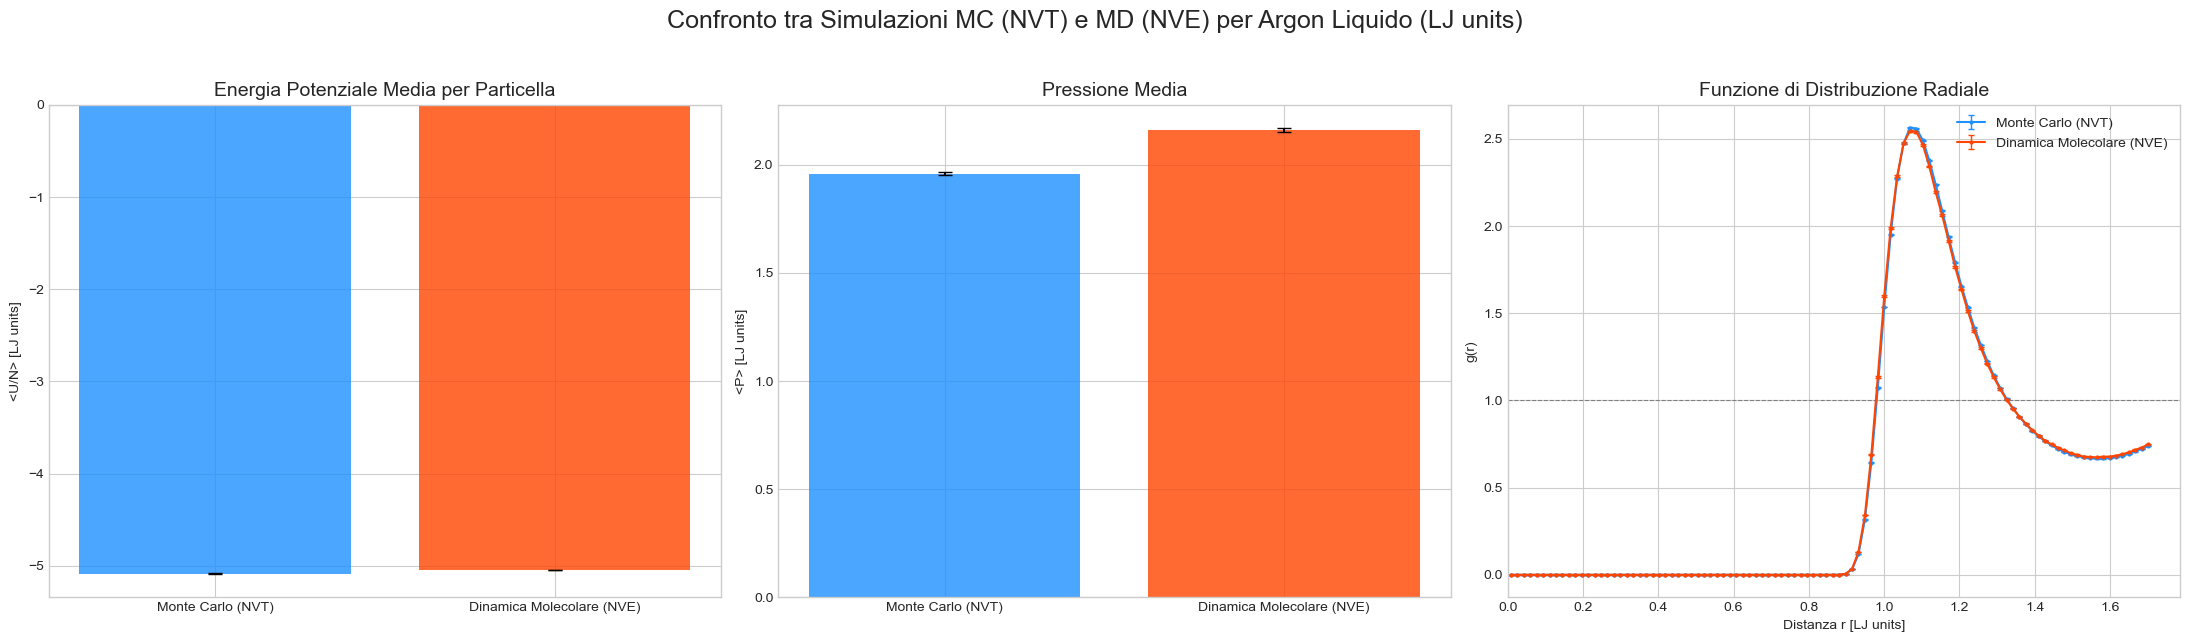

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configurazione ---

# Imposta uno stile grafico per i plot
plt.style.use('seaborn-v0_8-whitegrid')

# Definiamo la cartella principale dove sono stati salvati i risultati
RESULTS_DIR = "RESULTS_2"

# Definiamo le simulazioni da analizzare e confrontare
simulations_to_analyze = {
    "NVT": {
        "folder": os.path.join(RESULTS_DIR, "NVT_ARGON_LIQUID"),
        "label": "Monte Carlo (NVT)",
        "color": "dodgerblue"
    },
    "NVE": {
        "folder": os.path.join(RESULTS_DIR, "NVE_ARGON_LIQUID"),
        "label": "Dinamica Molecolare (NVE)",
        "color": "orangered"
    }
}

# Dizionario per salvare i dati caricati
results_data = {}

# --- 2. Caricamento e Analisi Dati ---

print("--- Caricamento Dati Finali dalle Simulazioni ---")

for key, sim_info in simulations_to_analyze.items():
    folder = sim_info["folder"]
    results_data[key] = {}
    
    try:
        # Carica Energia Potenziale (ultimo blocco)
        epot_file = os.path.join(folder, "potential_energy.dat")
        epot_data = np.loadtxt(epot_file)
        results_data[key]['epot_avg'] = epot_data[-1, 2] # Media finale
        results_data[key]['epot_err'] = epot_data[-1, 3] # Errore finale
        print(f"Caricata Energia Potenziale per {key}...")

        # Carica Pressione (ultimo blocco)
        pres_file = os.path.join(folder, "pressure.dat")
        pres_data = np.loadtxt(pres_file)
        results_data[key]['pres_avg'] = pres_data[-1, 2] # Media finale
        results_data[key]['pres_err'] = pres_data[-1, 3] # Errore finale
        print(f"Caricata Pressione per {key}...")

        # Carica Funzione di Distribuzione Radiale g(r)
        gofr_file = os.path.join(folder, "gofr.dat")
        gofr_data = np.loadtxt(gofr_file)
        results_data[key]['r'] = gofr_data[:, 0]
        results_data[key]['g_of_r'] = gofr_data[:, 1]
        results_data[key]['g_of_r_err'] = gofr_data[:, 2]
        print(f"Caricata g(r) per {key}...")

    except FileNotFoundError as e:
        print(f"ERRORE: File non trovato -> {e.filename}")
        print(" -> Assicurati di aver eseguito lo script di simulazione e che i file siano in '{folder}'.")
        # Rimuoviamo la chiave se i dati non sono completi
        results_data.pop(key, None)

print("-" * 50 + "\n")

# --- 3. Visualizzazione e Confronto ---

if len(results_data) == 2: # Procedi solo se entrambi i set di dati sono stati caricati
    print("--- Creazione Grafici di Confronto ---")
    
    # Crea una figura con 3 subplots (1 riga, 3 colonne)
    fig, axes = plt.subplots(1, 3, figsize=(22, 6.5))
    fig.suptitle("Confronto tra Simulazioni MC (NVT) e MD (NVE) per Argon Liquido (LJ units)", fontsize=18)

    # Grafico 1: Energia Potenziale Media
    ax1 = axes[0]
    sim_labels = [sim['label'] for sim in simulations_to_analyze.values()]
    epot_avgs = [results_data[key]['epot_avg'] for key in simulations_to_analyze.keys()]
    epot_errs = [results_data[key]['epot_err'] for key in simulations_to_analyze.keys()]
    colors = [sim['color'] for sim in simulations_to_analyze.values()]
    
    ax1.bar(sim_labels, epot_avgs, yerr=epot_errs, color=colors, capsize=5, alpha=0.8)
    ax1.set_title("Energia Potenziale Media per Particella", fontsize=14)
    ax1.set_ylabel("<U/N> [LJ units]")
    ax1.grid(True, axis='y')

    # Grafico 2: Pressione Media
    ax2 = axes[1]
    pres_avgs = [results_data[key]['pres_avg'] for key in simulations_to_analyze.keys()]
    pres_errs = [results_data[key]['pres_err'] for key in simulations_to_analyze.keys()]

    ax2.bar(sim_labels, pres_avgs, yerr=pres_errs, color=colors, capsize=5, alpha=0.8)
    ax2.set_title("Pressione Media", fontsize=14)
    ax2.set_ylabel("<P> [LJ units]")
    ax2.grid(True, axis='y')

    # Grafico 3: Funzione di Distribuzione Radiale g(r)
    ax3 = axes[2]
    for key, sim_info in simulations_to_analyze.items():
        r = results_data[key]['r']
        g_r = results_data[key]['g_of_r']
        g_r_err = results_data[key]['g_of_r_err']
        ax3.errorbar(r, g_r, yerr=g_r_err, label=sim_info['label'], color=sim_info['color'],
                     marker='.', markersize=4, linestyle='-', elinewidth=1, capsize=2)
    
    ax3.set_title("Funzione di Distribuzione Radiale", fontsize=14)
    ax3.set_xlabel("Distanza r [LJ units]")
    ax3.set_ylabel("g(r)")
    ax3.axhline(1, color='grey', linestyle='--', linewidth=0.8) # Linea di riferimento per il gas ideale
    ax3.legend()
    ax3.grid(True)
    ax3.set_xlim(left=0) # Parte da r=0

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Aggiusta layout per il titolo principale
    plt.show()

else:
    print("Analisi non eseguita: dati mancanti per una o entrambe le simulazioni.")

### Analisi dei risultati

Il confronto tra le medie d'insieme calcolate con le simulazioni Monte Carlo (NVT) e di Dinamica Molecolare (NVE) mostra una forte coerenza fisica, validando l'implementazione di entrambi i metodi.

* **Energia potenziale e funzione di distribuzione radiale**: I risultati per l'energia potenziale media per particella, $\langle U/N \rangle$, e per la funzione di distribuzione radiale, $g(r)$, evidenziano un accordo eccellente. I valori medi sono perfettamente compatibili. Questa coerenza dimostra che entrambi gli approcci algoritmici stanno campionando in modo corretto lo stesso stato fisico di equilibrio, caratterizzato da una precisa struttura microscopica e da una corrispondente energia potenziale media.

* **Pressione**: Anche i valori della pressione, per quanto incompatibili, sono abbastanza in accordo. La piccola discrepanza residua, con la pressione NVE leggermente superiore a quella NVT, non è attribuibile a un errore di programmazione, bensì a un effetto fisico atteso in sistemi con un numero finito di particelle. Le medie termodinamiche calcolate nell'insieme microcanonico (NVE) e canonico (NVT) convergono allo stesso valore solo nel limite termodinamico ($N \to \infty$). Per un sistema di dimensioni ridotte (N=32), una lieve differenza tra i due insiemi è pertanto fisicamente plausibile.

Risulta inoltre sensato che soltanto la pressione mostra discrepanze significative, in quanto è una quantità termodinamicamente più complessa, la cui formula include sia un termine viriale (legato alle forze interparticellari) sia un termine cinetico ($\rho T$). Grandezze legate a fluttuazioni o a derivate seconde dei potenziali termodinamici, come la pressione, sono note per essere più sensibili alla scelta dell'ensemble statistico rispetto a grandezze come l'energia interna.

### Supplementary activity ... just for your fun!
Note that he following **is not** part of the Numerical Exercise 7; if you had fun with exercises 7.* and you are courious, you could try to repeat exercises 7.2 and 7.4 in the following different thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r^\star_c = 2.2$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r^\star_c = 5.0$)